# Linear and convolutional autoencoders

An autoencoder is a neural network that can be used to encode and decode data. The general structure of an autoencoder is shown in the figure below. It consists of two parts: an encoder and a decoder. The encoder compresses the input data into a lower dimensional representation (often referred to as the _latent space representation_) by extracting the most salient features of the data, while the decoder reconstructs the input data from the compressed representation. Therefore, autoencoder is often used for _dimensionality reduction_. In this tutorial, our goal is to compare the performance of two types of autoencoders, a linear autoencoder and a convolutional autoencoder, on reconstructing the [`Fashion-MNIST`](https://github.com/zalandoresearch/fashion-mnist) images. With the help of Covalent, we will see how to break a complex workflow into smaller and more manageable tasks, which allows users to track the task dependencies and execution results of individual steps. Another advantage of Covalent is its ability to auto-parallelize the execution of subtasks.

<div align="center">
<img src="././autoencoder_images/schematic.png" style="width: 40%; height: 40%"/>
</div>


## Building the autoencoders

We will build the two types of autoencoders in [PyTorch](https://pytorch.org/). The linear autoencoder is built on the [`Linear`](https://pytorch.org/docs/stable/generated/torch.nn.Linear.html#torch.nn.Linear) layers, while the convolutional autoencoder is built on the [`Conv2d`](https://pytorch.org/docs/stable/nn.html#torch.nn.Conv2d) layers. Let us first install all the necessary dependencies for this tutorial.


In [1]:
# !pip install cova
# !pip install torch torchvision
# !pip install matplotlib
# !pip install numpy

We can then start the Covalent UI and the local dispatcher server by running `!covalent start`. The UI will be available at http://localhost:8080. Next, we import the following modules:


In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
from torchvision import datasets, transforms
import covalent as ct

The linear and convolutional autoencoders are implemented as classes inheriting from the [`nn.Module`](https://pytorch.org/docs/stable/generated/torch.nn.Module.html) class in PyTorch. We will define two function called `create_linear_ae` and `create_conv_ae` to create the linear and convolutional autoencoders, respectively, and add the `electron` decorator on top to make them part of the Covalent workflow. The advantage of doing this is that various parts of the autoencoder network such as the number of hidden layers and their sizes can be parameterized by the user for experimentation. For this tutorial, we will use a fixed architecture for each of them for the sake of simplicity.

In the case of a linear autoencoder, we will use four hidden layers in the encoder. Between each layer the `ReLU` activation function is applied. The decoder is essentially the "inverse" of the encoder, and we will use the same architecture for it except at the end an additional `Sigmoid` activation function is applied. The choice of this activation function depends on the range of the pixel intensity in the original input data. Note that the `Fashion-MNIST` dataset contains 28x28-pixel gray-scale images, so the input dimension of each image is 28x28x1. The compressed images generated by the encoder in this case would have dimension 3x3x1 in this case. In addition, 


In [3]:
@ct.electron
def create_linear_ae():
    class LinearAutoencoder(nn.Module):
        """Autoencoder with 4 hidden layers."""

        def __init__(self):
            super(LinearAutoencoder, self).__init__()
            self.encoder = nn.Sequential(
                nn.Linear(28*28, 128),  # input size = 784 -> hidden size = 128
                nn.ReLU(True),
                nn.Linear(128, 64),  # hidden size = 128 -> hidden size = 64
                nn.ReLU(True),
                nn.Linear(64, 12),  # hidden size = 64 -> hidden size = 12
                nn.ReLU(True),
                nn.Linear(12, 3),  # hidden size = 12 -> output size = 3
            )
            self.decoder = nn.Sequential(
                nn.Linear(3, 12),  # input size = 3 -> hidden size = 12
                nn.ReLU(True),
                nn.Linear(12, 64),  # hidden size = 12 -> hidden size = 64
                nn.ReLU(True),
                nn.Linear(64, 128),  # hidden size = 64 -> hidden size = 128
                nn.ReLU(True),
                nn.Linear(128, 28*28),  # hidden size = 128 -> output size = 784
                nn.Sigmoid()  # output with pixel intensity in [0,1]
            )

        def forward(self, x):
            encoded = self.encoder(x)
            decoded = self.decoder(encoded)
            return decoded
    
    return LinearAutoencoder()

For the convolutional autoencoder, we will use three hidden layers. Each convolutional layer except for the last one in the encoder will use the `Conv2d` construction with a kernel size of 3x3, a stride of 1, and a padding of 1, followed by a `ReLU` activation function. The decoder will use the `ConvTranspose2d` layers to reverse the action of the `Conv2d` layers in the encoder, followed by a `Sigmoid` activation function.


In [4]:
def create_conv_ae():
    class ConvAutoencoder(nn.Module):
        """Autoencoder with 3 hidden layers."""

        def __init__(self):
            super(ConvAutoencoder, self).__init__()
            self.encoder = nn.Sequential(
                nn.Conv2d(1, 16, 3, stride=2, padding=1),  # input size = 1x28x28 -> hidden size = 16x14x14
                nn.ReLU(True),
                nn.Conv2d(16, 32, 3, stride=2, padding=1),  # hidden size = 16x14x14 -> hidden size = 32x7x7
                nn.ReLU(True),
                nn.Conv2d(32, 64, 7),  # hidden size = 32x7x7 -> hidden size = 64x1x1
            )

            self.decoder = nn.Sequential(
                nn.ConvTranspose2d(64, 32, 7),  # input size = 64x1x1 -> hidden size = 32x7x7
                nn.ReLU(True),
                nn.ConvTranspose2d(32, 16, 3, stride=2, padding=1, output_padding=1),  # hidden size = 32x7x7 -> hidden size = 16x14x14
                nn.ReLU(True),
                nn.ConvTranspose2d(16, 1, 3, stride=2, padding=1, output_padding=1),  # hidden size = 16x14x14 -> hidden size = 1x28x28
                nn.Sigmoid()  # output with pixels in [0,1]
            )

        def forward(self, x):
            encoded = self.encoder(x)
            decoded = self.decoder(encoded)
            return decoded

    return ConvAutoencoder()

## Creating the workflow


Let us now build a workflow that can encompass both autoencoders. Overall, the workflow consists of five tasks. We begin by creating a `data_loader` that loads the data from the `Fashion-MNIST` dataset, along with custom preprocessing if necessary. We will add the `electron` decorator on this function, making it a subtask in the Covalent workflow.


In [5]:
@ct.electron
def data_loader(
    batch_size: int,
    train: bool,
    download: bool = True,
    shuffle: bool = True,
    transform: transforms.Compose = None,
) -> torch.utils.data.DataLoader:
    """
    Loads the Fashion MNIST dataset.

    Args:
        batch_size: The batch size.
        train: Whether to load the training or test set.
        download: Whether to download the dataset.
        shuffle: Whether to shuffle the dataset.
        transform: A transform to apply to the dataset.

    Returns:
        A DataLoader for the Fashion MNIST dataset.
    """
    if transform is None:
        transform = transforms.Compose([transforms.ToTensor()])

    dataset = datasets.FashionMNIST(
        "./data", train=train, download=download, transform=transform
    )

    return torch.utils.data.DataLoader(
        dataset, batch_size=batch_size, shuffle=shuffle
    )

Then we define the training process over multiple epochs. To optimize the autoencoders, we choose the [`Adam`](https://pytorch.org/docs/stable/generated/torch.optim.Adam.html#torch.optim.Adam) optimizer as our optimizer and the mean squared error (`MSE`) between the original and reconstructed images as the reconstruction loss. During training, we will keep track of the reconstruction loss after each epoch. We will also log the output images after a certain number of epochs specified by the `log_interval`.

In [6]:
@ct.electron
def train_model(
    model: nn.Module,
    lr: float,
    data_loader: torch.utils.data.DataLoader,
    epochs: int,
    log_interval: int,
):
    """
    Trains the given model on the Fashion MNIST dataset.

    Args:
        model: A PyTorch model.
        lr: The learning rate.
        data_loader: A DataLoader for the Fashion MNIST dataset.
        epochs: The number of epochs to train for.
        log_interval: The number of epochs to wait before logging in the outputs.

    Returns:
        train_loss: A list of training losses for each epoch.
        outputs: Contains epoch number, the original image, and the reconstructed image at each training step.
        model: The trained model.
    """
    optimizer = optim.Adam(model.parameters(), lr=lr)
    model.train()
    outputs = []
    train_loss = []
    print(f"Training {model.__class__.__name__}")
    for epoch in range(1, epochs + 1):
        running_loss = 0
        for (data, _) in data_loader:
            if model.__class__.__name__ == 'LinearAutoencoder':
                data = data.view(data.size(0), -1)
            recon = model(data)
            loss = nn.MSELoss()(recon, data)  # mean squared error loss
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        loss = running_loss / len(data_loader)
        train_loss.append(loss)
        if epoch % log_interval == 0:
            outputs.append((epoch, data, recon))
            print(f"Epoch {epoch}, loss: {loss}")
    return train_loss, outputs, model

After the training is complete, we will test the performance of our autoencoders on the test set and compare the average test loss with the training losses.

In [7]:
@ct.electron
def test_model(
    model: nn.Module, 
    data_loader: torch.utils.data.DataLoader,
):
    """
    Tests the given model on the Fashion MNIST dataset.

    Args:
        model: A PyTorch model.
        data_loader: A DataLoader for the Fashion MNIST dataset.

    Returns:
        avg_test_loss: The average loss for the test set.
    """
    model.eval()
    test_loss = 0
    with torch.no_grad():
        for (data, _) in data_loader:
            if model.__class__.__name__ == 'LinearAutoencoder':
                data = data.view(data.shape[0], -1)
            recon = model(data)
            loss = nn.MSELoss()(recon, data)  # mean squared error loss
            test_loss += loss.item()
    avg_test_loss = test_loss / len(data_loader)
    print(f"Average test loss: {avg_test_loss}")
    return avg_test_loss

With the above subtasks properly set up, it is time to bundle them into one single workflow that can be dispatched using Covalent.

In [8]:
@ct.lattice
def experiment(
    model: nn.Module,
    epochs: int,
    log_interval: int,
    batch_size_train: int = 64,
    batch_size_test: int = 1000,
    lr: float = 1e-3
):
    """
    Workflow of training and testing a given autoencoder (linear or convolutional) on the Fashion MNIST dataset.

    Args:
        model: A PyTorch model.
        epochs: The number of epochs to train for.
        log_interval: The number of epochs to wait before logging in the outputs.
        batch_size_train: The batch size for the training set.
        batch_size_test: The batch size for the test set.
        lr: The learning rate.

    Returns:
        train_loss: The training loss at each epoch.
        avg_test_loss: The average loss for the test set.
        outputs: Contains epoch number, the original image, and the reconstructed image at each training step.
    """
    train_loader = data_loader(batch_size=batch_size_train, train=True)
    test_loader = data_loader(batch_size=batch_size_test, train=False)

    train_loss, outputs, model = train_model(
        model=model,
        lr=lr,
        data_loader=train_loader,
        epochs=epochs,
        log_interval=log_interval,
    )
    avg_test_loss = test_model(model=model, data_loader=test_loader)
    
    return train_loss, avg_test_loss, outputs

## Linear vs. convolutional autoencoders

We will now run the workflow for both the linear and convolutional autoencoders and compare their performances.

In [9]:
lin_dispatch_id = ct.dispatch(experiment)(model=create_linear_ae(),epochs=40, log_interval=10)
lin_result = ct.get_result(dispatch_id=lin_dispatch_id, wait=True)
lin_train_loss, lin_avg_test_loss, lin_outputs = lin_result.result

In [10]:
conv_dispatch_id = ct.dispatch(experiment)(model=create_conv_ae(),epochs=40, log_interval=10)
conv_result = ct.get_result(dispatch_id=conv_dispatch_id, wait=True)
conv_train_loss, conv_avg_test_loss, conv_outputs = conv_result.result

Let us take a look at the outputs of the print statements during the training and testing processes. They are stored in the `./results/[dispatch_id]/stdout.log` directory. They can also be accessed from the Covalent UI. Here are the outputs for the linear and convolutional autoencoder experiments that we just ran:

<div align="center">
<img src="././autoencoder_images/outputs.png" style="width: 80%; height: 80%"/>
</div>

There are a few key takeaways from the above outputs: 1) For both autoencoders, the training loss is decreasing with an increasing number of epochs, indicating that the training was successful. 2) The average test loss for 1000 images is about the same as the final training loss. This means that both autoencoders have pretty good generalizability. 3) The loss of the the convolutional autoencoder is just about 1/4 that of the linear autoencoder after 40 epochs, even when the convolutional autoencoder has one fewer hidden layer than its linear counterpart. This is expected since the convolutional neural network is more complex and generally performs better with image data. However, it also took a longer time to optimize the convolutional model under the same number of epochs. We can also inspect the whole training history for both autoencoders, which was saved while running the experiments.

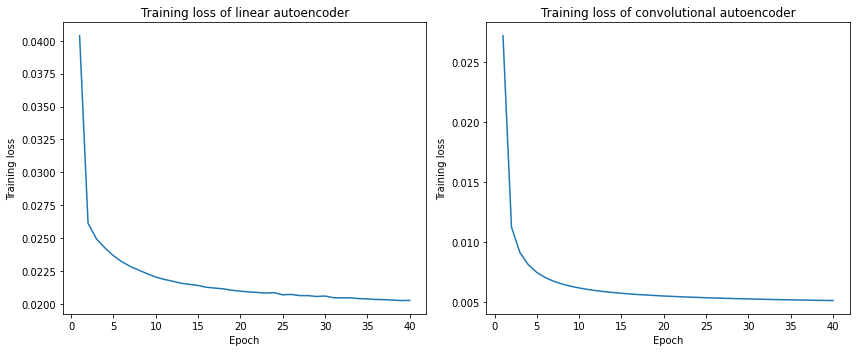

In [11]:
fig, axarr = plt.subplots(1, 2, figsize=(12, 5), facecolor="w")
axarr[0].plot(np.arange(1, len(lin_train_loss)+1), lin_train_loss)
axarr[0].set_title("Training loss of linear autoencoder")
axarr[0].set_xlabel("Epoch")
axarr[0].set_ylabel("Training loss")
axarr[1].plot(np.arange(1, len(conv_train_loss)+1), conv_train_loss)
axarr[1].set_title("Training loss of convolutional autoencoder")
axarr[1].set_xlabel("Epoch")
axarr[1].set_ylabel("Training loss")
fig.tight_layout()
plt.show()

Again, the plots above confirms the success of our experiments. Lastly, we also want to display a few images at different phases of training to help us visualize how the reconstructed images compare with the original ones.

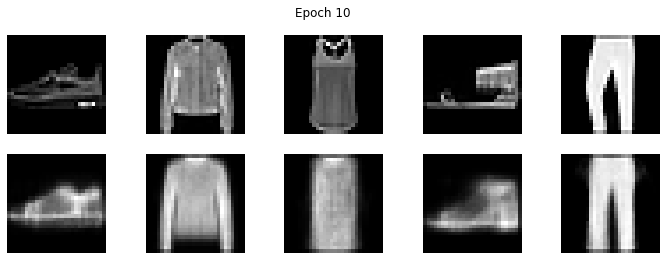

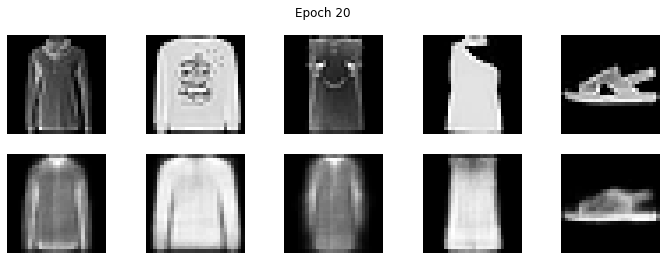

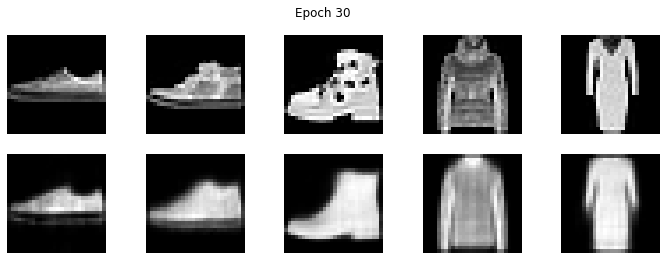

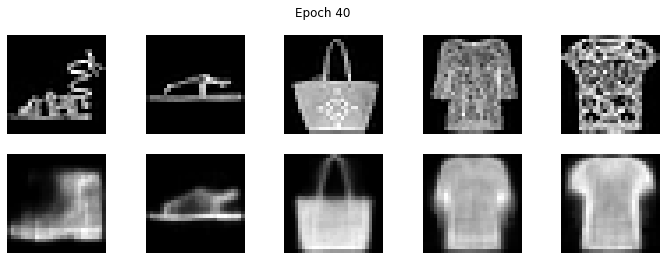

In [12]:
def plot_outputs(outputs: tuple):
    """
    Plots the outputs of the workflow.

    Args:
        outputs: The outputs of the workflow.
    """
    for i in range(len(outputs)):
        plt.figure(figsize=(12, 4), facecolor="w")
        plt.gray()
        plt.suptitle(f'Epoch {outputs[i][0]}')
        imgs = outputs[i][1].detach().numpy()  # original images
        recon = outputs[i][2].detach().numpy()  # reconstructed images
        for j, item in enumerate(imgs):
            while j < 5:
                plt.subplot(2, 5, j + 1)
                item = item.reshape(-1, 28, 28)
                plt.imshow(item[0])
                plt.axis("off")
                j += 1
        
        for j, item in enumerate(recon):
            while j < 5:
                plt.subplot(2, 5, j + 6)
                item = item.reshape(-1, 28, 28)
                plt.imshow(item[0])
                plt.axis("off")
                j += 1

plot_outputs(lin_outputs)

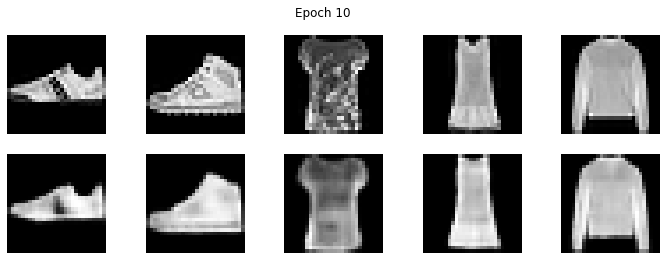

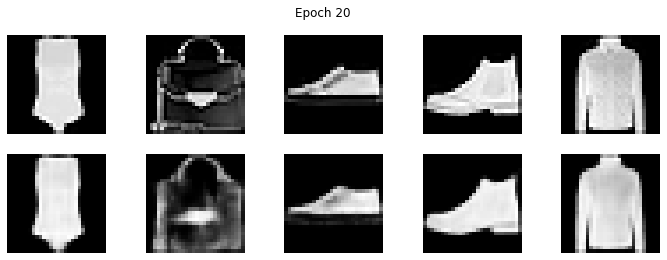

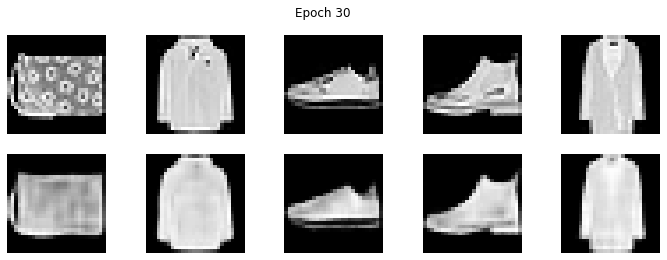

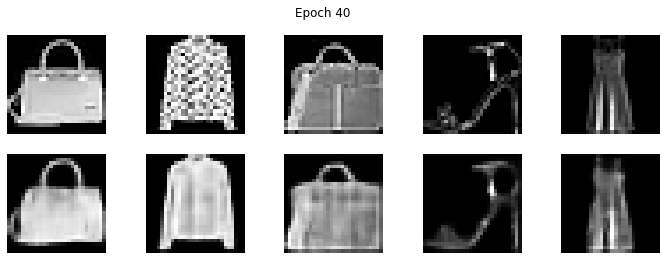

In [13]:
plot_outputs(conv_outputs)